In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Qiskit Imports
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_machine_learning.neural_networks import SamplerQNN

# IBM Cloud Imports (To musisz doinstalować: pip install qiskit-ibm-runtime)
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit import transpile  # <--- WAŻNY NOWY IMPORT

In [16]:
TRAIN_PATIENTS = ['100', '101', '102']
TEST_PATIENTS = ['106', '119']

SAMPLES_BEFORE = 30
SAMPLES_AFTER = 60
WINDOW_SIZE = SAMPLES_BEFORE + SAMPLES_AFTER

# Cechy PCA - tyle kubitów
N_DIM = 8
LIMIT_PER_PATIENT = 600

NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']
ANOMALY_SYMBOLS = ['V', 'A', 'a', 'J', 'S', 'F', '!', 'E', '/']

In [17]:
def load_patient_data(patiend_id):
    # Wczytuje sygnał i wycina uderzenia na podstawie adnotacji
    ekg_file = f'archive/{patiend_id}_ekg.csv'
    ann_file = f'archive/{patiend_id}_annotations_1.csv'
    
    if not os.path.exists(ekg_file) or not os.path.exists(ann_file):
        print('nie ma pliku')
        return [], []
    
    # wczytywanie sygnału ekg dla pacjenta, szukam po tej kolumnie MLII
    df_ekg = pd.read_csv(ekg_file)
    # Usuwamy spacje z nazw kolumn (częsty błąd w CSV)
    df_ekg.columns = df_ekg.columns.str.strip()
    
    try:
        if 'MLII' in df_ekg.columns:
                signal = df_ekg['MLII'].values
        elif 'V5' in df_ekg.columns:
            signal = df_ekg['V5'].values
        else:
            # Jeśli nie ma nazw, bierzemy kolumnę indeks 1 (bo 0 to zazwyczaj czas/sample)
            signal = df_ekg.iloc[:, 1].values
    except Exception as e:
        print(f'error {e}')
        return [], []
    
    den = np.max(signal) - np.min(signal)
    if den == 0:
        return [], []
    signal = (signal - np.min(signal)) / den
    
    try:
        df_ann = pd.read_csv(ann_file)
        df_ann.columns = df_ann.columns.str.strip() # Czyścimy nazwy
            
        # Szukamy odpowiednich kolumn (sample = pozycja, symbol = typ)
        # Czasami nazywają się 'sample', 'Sample', 'time', etc.
        sample_col = next((c for c in df_ann.columns if 'index' in c.lower()), None)
        symbol_col = next((c for c in df_ann.columns if 'annotation_symbol' in c.lower()), None)
        
        if not sample_col or not symbol_col:
            print("  Nie znaleziono kolumn 'sample' lub 'symbol' w adnotacjach.")
            return [], []
        
        peaks = df_ann[sample_col].values
        symbols = df_ann[symbol_col].values
    except Exception as e:
        print(f'blad {e}')
        return [], []
    
    beats_normal = []
    beats_anomaly = []
    
    for p, sym in zip(peaks, symbols):
        # Pomijamy uderzenia na samym początku lub końcu nagrania
        if p - SAMPLES_BEFORE < 0 or p + SAMPLES_AFTER > len(signal):
            continue
            
        # Wycinek
        window = signal[p - SAMPLES_BEFORE : p + SAMPLES_AFTER]
        
        # Upewniamy się, że długość jest idealna
        if len(window) != WINDOW_SIZE:
            continue

        # Klasyfikacja
        if sym in NORMAL_SYMBOLS:
            if len(beats_normal) < LIMIT_PER_PATIENT:
                beats_normal.append(window)
        elif sym in ANOMALY_SYMBOLS:
            if len(beats_anomaly) < LIMIT_PER_PATIENT:
                beats_anomaly.append(window)
                
    print(f"  -> Znaleziono: {len(beats_normal)} Normal, {len(beats_anomaly)} Anomaly")
    return beats_normal, beats_anomaly

>>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...
  -> Znaleziono: 600 Normal, 34 Anomaly
  -> Znaleziono: 600 Normal, 3 Anomaly
  -> Znaleziono: 99 Normal, 600 Anomaly

>>> KROK 2: Wczytywanie danych testowych (Mieszane)...
  -> Znaleziono: 600 Normal, 520 Anomaly
  -> Znaleziono: 600 Normal, 444 Anomaly

STATUS DANYCH SUROWYCH:
Wymiar pojedynczego uderzenia: 90 próbek
Liczba próbek Train (Normal): 1299
Liczba próbek Test (Normal): 1200
Liczba próbek Test (Anomaly): 964

>>> KROK 3: Redukcja wymiaru (PCA) z 90 do 8...
Wyjaśniona wariancja (ile info zachowaliśmy): 99.48%
>>> KROK 4: Skalowanie do zakresu (0, pi)...
Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib

>>> KROK 5: Zapisywanie plików .npy...
GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.

>>> Generowanie wykresu kontrolnego...


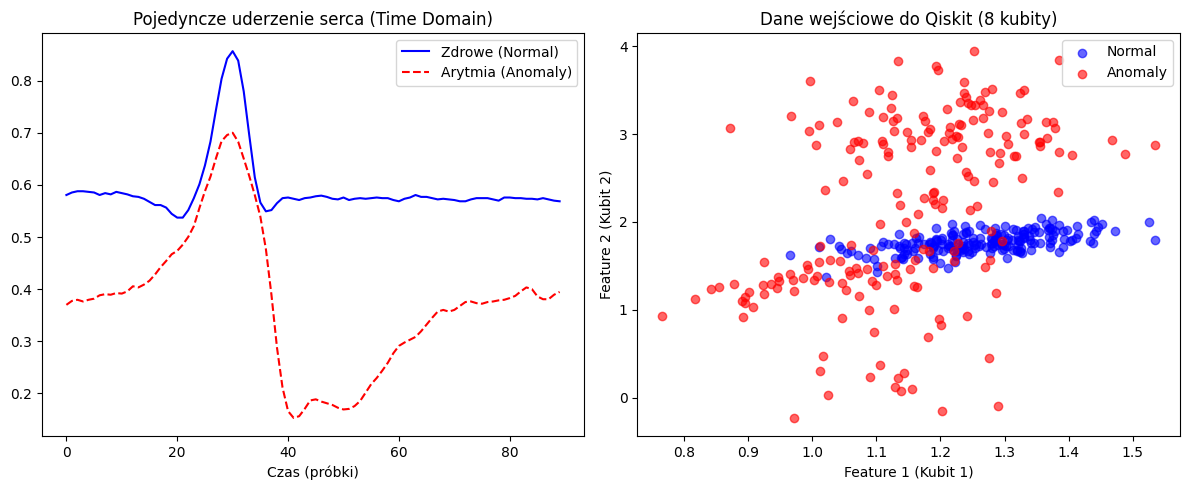

In [18]:
# --- ZBIERANIE DANYCH ---
all_train_normal = []
all_test_normal = []
all_test_anomaly = []

print(">>> KROK 1: Wczytywanie danych treningowych (Zdrowi)...")
for pid in TRAIN_PATIENTS:
    n, _ = load_patient_data(pid)
    all_train_normal.extend(n)

print("\n>>> KROK 2: Wczytywanie danych testowych (Mieszane)...")
for pid in TEST_PATIENTS:
    n, a = load_patient_data(pid)
    all_test_normal.extend(n)
    all_test_anomaly.extend(a)

# Konwersja na numpy array
X_train = np.array(all_train_normal)
X_test_normal = np.array(all_test_normal)
X_test_anomaly = np.array(all_test_anomaly)

print(f"\nSTATUS DANYCH SUROWYCH:")
print(f"Wymiar pojedynczego uderzenia: {WINDOW_SIZE} próbek")
print(f"Liczba próbek Train (Normal): {X_train.shape[0]}")
print(f"Liczba próbek Test (Normal): {X_test_normal.shape[0]}")
print(f"Liczba próbek Test (Anomaly): {X_test_anomaly.shape[0]}")

if len(X_train) == 0:
    print("BŁĄD KRYTYCZNY: Brak danych treningowych. Sprawdź nazwy plików CSV!")
    raise ValueError

# --- PRZETWARZANIE (PCA) ---
print(f"\n>>> KROK 3: Redukcja wymiaru (PCA) z {WINDOW_SIZE} do {N_DIM}...")

# 1. Trenujemy PCA tylko na zdrowych danych treningowych
pca = PCA(n_components=N_DIM)
pca.fit(X_train)

# 2. Transformujemy wszystkie zbiory
X_train_pca = pca.transform(X_train)
X_test_normal_pca = pca.transform(X_test_normal)

# Obsługa przypadku, gdyby nie było anomalii (żeby kod nie padł)
if len(X_test_anomaly) > 0:
    X_test_anomaly_pca = pca.transform(X_test_anomaly)
else:
    X_test_anomaly_pca = np.empty((0, N_DIM))

print(f"Wyjaśniona wariancja (ile info zachowaliśmy): {sum(pca.explained_variance_ratio_):.2%}")

# --- SKALOWANIE DO KOMPUTERA KWANTOWEGO ---
# Qiskit lubi dane w zakresie (0, pi) lub (-1, 1). 
# Użyjemy (0, pi) pod bramki rotacji.
print(">>> KROK 4: Skalowanie do zakresu (0, pi)...")

scaler = MinMaxScaler(feature_range=(0, np.pi))
scaler.fit(X_train_pca) # Uczymy skaler na treningu

joblib.dump(
    {
    "pca": pca,
    "scaler": scaler,
    "n_dim": N_DIM,
    "window_size": WINDOW_SIZE
    },
    "ibm_preprocessing_8dim.joblib"
)
print("Zapisano PCA i scaler do pliku: preprocessing_8dim.joblib")

X_train_final = scaler.transform(X_train_pca)
X_test_normal_final = scaler.transform(X_test_normal_pca)

if len(X_test_anomaly) > 0:
    X_test_anomaly_final = scaler.transform(X_test_anomaly_pca)
else:
    X_test_anomaly_final = X_test_anomaly_pca

# --- ZAPISYWANIE ---
print("\n>>> KROK 5: Zapisywanie plików .npy...")
np.save('train_data.npy', X_train_final)
np.save('test_normal.npy', X_test_normal_final)
np.save('test_anomaly.npy', X_test_anomaly_final)
print("GOTOWE! Możesz teraz uruchomić skrypt z Qiskit.")

# --- WIZUALIZACJA ---
print("\n>>> Generowanie wykresu kontrolnego...")
plt.figure(figsize=(12, 5))

# Wykres 1: Jak wygląda surowe uderzenie?
plt.subplot(1, 2, 1)
plt.plot(X_train[0], label='Zdrowe (Normal)', color='blue')
if len(X_test_anomaly) > 0:
    plt.plot(X_test_anomaly[0], label='Arytmia (Anomaly)', color='red', linestyle='--')
plt.title("Pojedyncze uderzenie serca (Time Domain)")
plt.xlabel("Czas (próbki)")
plt.legend()

# Wykres 2: Jak to wygląda po PCA?
plt.subplot(1, 2, 2)
# Rysujemy tylko po 100 kropek żeby było czytelnie
plt.scatter(X_test_normal_final[:200, 0], X_test_normal_final[:200, 1], 
            c='blue', alpha=0.6, label='Normal')
if len(X_test_anomaly_final) > 0:
    plt.scatter(X_test_anomaly_final[:200, 0], X_test_anomaly_final[:200, 1], 
                c='red', alpha=0.6, label='Anomaly')
plt.title(f"Dane wejściowe do Qiskit ({N_DIM} kubity)")
plt.xlabel("Feature 1 (Kubit 1)")
plt.ylabel("Feature 2 (Kubit 2)")
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Marcepano\AppData\Local\Temp\ipykernel_11856\1588090683.py:25: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
C:\Users\Marcepano\AppData\Local\Temp\ipykernel_11856\1588090683.py:26: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> 1. Wczytywanie danych (8 cech)...
    Trening na: 1299 próbkach
>>> 2. Budowanie obwodu (8 kubitów)...
>>> 3. Start treningu (Optimizer: SPSA, Iter: 100)...
    Iter 10: Koszt = 0.5126
    Iter 20: Koszt = 0.4420
    Iter 30: Koszt = 0.4653
    Iter 40: Koszt = 0.4739
    Iter 50: Koszt = 0.6346
    Iter 60: Koszt = 0.2632
    Iter 70: Koszt = 0.2619
    Iter 80: Koszt = 0.2282
    Iter 90: Koszt = 0.1711
    Iter 100: Koszt = 0.1848
    Iter 110: Koszt = 0.1558
    Iter 120: Koszt = 0.1454
    Iter 130: Koszt = 0.1673
    Iter 140: Koszt = 0.1747
    Iter 150: Koszt = 0.0935
    Iter 160: Koszt = 0.1175
    Iter 170: Koszt = 0.1135
    Iter 180: Koszt = 0.1221
    Iter 190: Koszt = 0.1385
    Iter 200: Koszt = 0.1014
    Iter 210: Koszt = 0.1106
    Iter 220: Koszt = 0.1311
    Iter 230: Koszt = 0.1120
    Iter 240: Koszt = 0.1264
    Iter 250: Koszt = 0.1447
>>> Czas treningu: 118.6 s
>>> Wyniki optymalizacji: fun=0.082233
>>> 4. Generowanie wyników...


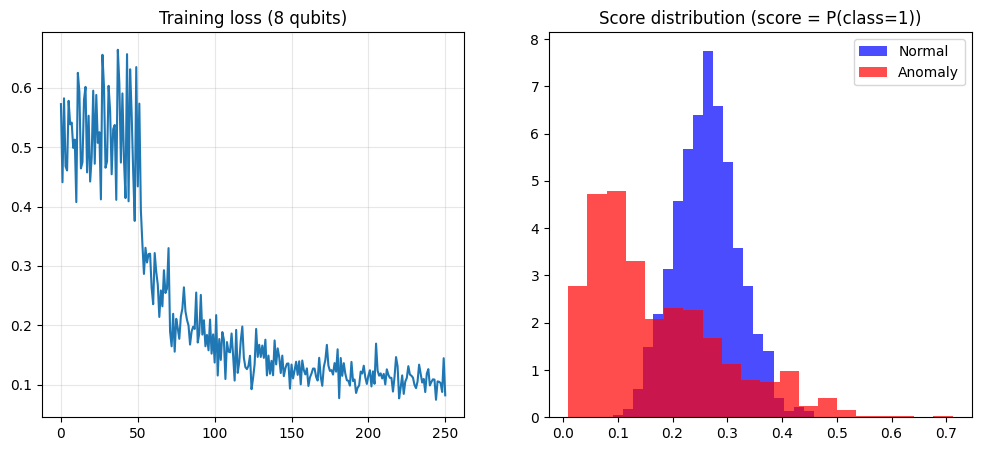

In [19]:
INPUT_DIM = N_DIM     # Teraz mamy 8 cech
MAX_ITER = 100     # Dajmy mu trochę czasu
BATCH_SIZE = 25 
EVAL_BATCH = 50

print(f">>> 1. Wczytywanie danych (8 cech)...")
try:
    train_data = np.load('train_data.npy')
    test_normal = np.load('test_normal.npy')
    test_anomaly = np.load('test_anomaly.npy')
except FileNotFoundError as e:
    raise FileNotFoundError("BŁĄD: Nie znaleziono plików. Uruchom najpierw prepare_data.py z N_DIM=8!") from e

if train_data.ndim != 2:
    raise ValueError(f"""BŁĄD: train_data ma wymiar: {train_data.ndim}, 
                     oczekiwano macierzy 2D (n_samples, n_fueatures).""")
if train_data.shape[1] != INPUT_DIM:
    raise ValueError(f"""BŁĄD: Dane mają wymair: {train_data.shape[1]},
                     a kod oczekuje {INPUT_DIM}.""")

print(f"    Trening na: {len(train_data)} próbkach")

# --- OBWÓD KWANTOWY ---
print(">>> 2. Budowanie obwodu (8 kubitów)...")
feature_map = ZFeatureMap(feature_dimension=INPUT_DIM, reps=1)
ansatz = RealAmplitudes(num_qubits=INPUT_DIM, reps=2, entanglement='linear')

qc = QuantumCircuit(INPUT_DIM)
qc.append(feature_map, range(INPUT_DIM))
qc.append(ansatz, range(INPUT_DIM))

def parity(x: int) -> int:
    return x % 2

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

# --- TRENING ---
objective_func_vals = []

def cost_func(params_values):
    BS = min(BATCH_SIZE, len(train_data))
    batch_idx = np.random.choice(len(train_data), BS, replace=False)
    batch_data = train_data[batch_idx]
    
    probs = qnn.forward(batch_data, params_values)
    p1 = np.clip(probs[:, 1], 1e-4, 1.0 - 1e-4)
    loss = float(np.mean(p1))

    objective_func_vals.append(loss)
    if len(objective_func_vals) % 10 == 0:
        print(f"    Iter {len(objective_func_vals)}: Koszt = {loss:.4f}")
    return loss

print(f">>> 3. Start treningu (Optimizer: SPSA, Iter: {MAX_ITER})...")

# --- ZMIANA TUTAJ ---
# COBYLA wyrzucamy:
# optimizer = COBYLA(maxiter=MAX_ITER) 

# Wstawiamy ADAM. 
# lr=0.01 to "learning rate". Jak wykres skacze jak szalony, zmniejsz do 0.001.
#optimizer = ADAM(maxiter=MAX_ITER, lr=0.01) 
optimizer = SPSA(maxiter=MAX_ITER)
initial_weights = 0.1 * (2 * np.random.random(ansatz.num_parameters) - 1)

start_t = time.time()
# ADAM wymaga gradientów, ale Qiskit SamplerQNN policzy je sobie sam (metodą różnic skończonych)
result = optimizer.minimize(fun=cost_func, x0=initial_weights)
print(f">>> Czas treningu: {time.time() - start_t:.1f} s")
print(f">>> Wyniki optymalizacji: fun={result.fun:.6f}")

# --- WYNIKI ---
print(">>> 4. Generowanie wyników...")
trained_weights = result.x

# Funkcja do ewaluacji (z batchem)
def get_scores_anomaly_prob(data):
    """ 
    Zwraca score = p1 (prawdopodobieństwo klasy 1 = 'anomaly' wg interpretacji QNN). 
    Jeśli etykietowanie jest odwrotne - zmienić na p[:, 0]
    """
    scores = []
    for i in range(0, len(data), EVAL_BATCH): # Mniejsze paczki dla 8 kubitów
        batch = data[i:i+EVAL_BATCH]
        p = qnn.forward(batch, trained_weights)
        p1 = p[:, 1]
        scores.extend(p1.tolist())
    return np.array(scores, dtype=float)

s_norm = get_scores_anomaly_prob(test_normal)
s_anom = get_scores_anomaly_prob(test_anomaly)

# --- WIZUALIZACJA ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(objective_func_vals)
plt.title(f"Training loss ({INPUT_DIM} qubits)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(s_norm, bins=20, alpha=0.7, color='Blue', label='Normal', density=True)
plt.hist(s_anom, bins=20, alpha=0.7, color='Red', label='Anomaly', density=True)
plt.title("Score distribution (score = P(class=1))")
plt.legend()

plt.savefig("results_8qubits.png")
plt.show()

In [20]:
scores = np.concatenate([s_norm, s_anom])
y_true = np.array([0]*len(s_norm) + [1]*len(s_anom))

def best_threshold(rule="greater"):
    # rule="greater": anomaly jeśli score > t
    # rule="less": anomaly jeśli score < t
    ts = np.quantile(scores, np.linspace(0.01, 0.99, 200))
    best = (-1, None)
    for t in ts:
        if rule == "greater":
            y_pred = (scores > t).astype(int)
        else:
            y_pred = (scores < t).astype(int)
        acc = accuracy_score(y_true, y_pred)
        if acc > best[0]:
            best = (acc, t)
    return best

acc_g, t_g = best_threshold("greater")
acc_l, t_l = best_threshold("less")

print("Best rule score > t:", acc_g, "t =", t_g)
print("Best rule score < t:", acc_l, "t =", t_l)

print("Means:", "mean_norm=", np.mean(s_norm), "mean_anom=", np.mean(s_anom))


Best rule score > t: 0.5785582255083179 t = 0.3867176308881402
Best rule score < t: 0.7925138632162662 t = 0.16601788234952441
Means: mean_norm= 0.26286482457657256 mean_anom= 0.16930050152555828



>>> Generowanie Macierzy Pomyłek...
--- WYNIKI DLA PROGU 0.14 ---
Dokładność (Accuracy): 79.67%
Precyzja (Precision):  92.67% (Ile z wykrytych arytmii to faktycznie arytmie?)
Czułość (Recall):      59.02% (Ile z prawdziwych arytmii udało się wykryć?)


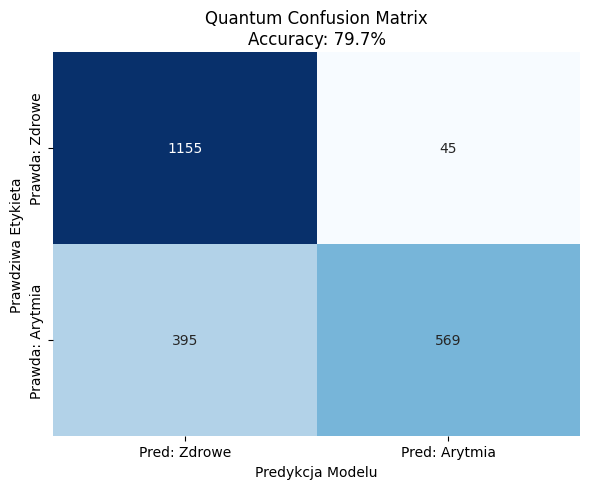

In [21]:
# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.14
THRESHOLD2 = 0.38

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(s_norm) + [1] * len(s_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in s_norm:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# Oceniamy chore
for score in s_anom:
    prediction = 1 if (score < THRESHOLD or score > THRESHOLD2) else 0
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu

qiskit_runtime_service._discover_account:WARNING:2026-02-03 14:00:49,206: Loading account with the given token. A saved account will not be used.



>>> 🚀 ROZPOCZYNAMY WALIDACJĘ NA IBM (TRYB JOB/V2)...


qiskit_runtime_service.__init__:WARNING:2026-02-03 14:00:52,858: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-03 14:00:53,430: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2026-02-03 14:00:55,413: Using instance: open-instance, plan: open


    Wybrano komputer: ibm_fez
    Oczekujących zadań: 0
    Wysyłam 40 próbek jako JEDEN JOB...
>>> Transpilacja obwodu do układu bramek sprzętu (ISA)...


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


>>> Czekanie na wynik z IBM Quantum (to chwilę potrwa)...
>>> JOB UKOŃCZONY! Wyniki pobrane.


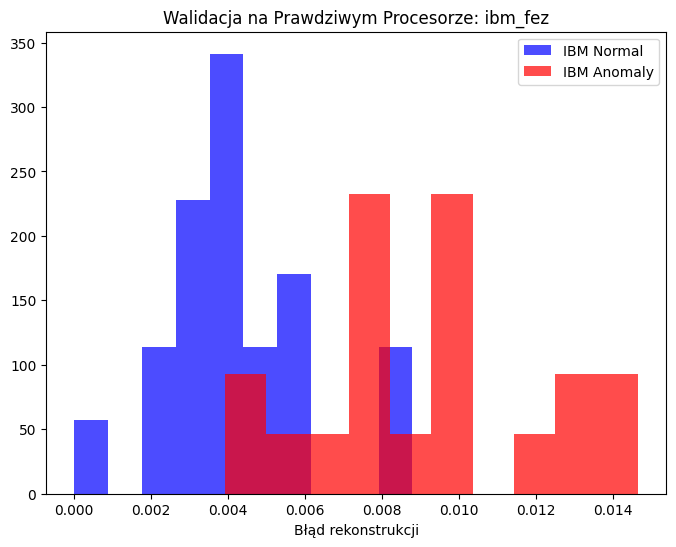

In [33]:
# TWÓJ TOKEN
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A",
    overwrite=True,
    set_as_default=True
)
MY_TOKEN = "ZGyUQq9SXiBMtV5mATQUKl2WfPJPSUIcj5T3pIpN2H0A" 

print("\n>>> 🚀 ROZPOCZYNAMY WALIDACJĘ NA IBM (TRYB JOB/V2)...")

# 1. Łączenie
service = QiskitRuntimeService(channel="ibm_quantum_platform", token=MY_TOKEN)
backend = service.least_busy(operational=True, simulator=False)
print(f"    Wybrano komputer: {backend.name}")
print(f"    Oczekujących zadań: {backend.status().pending_jobs}")

# 2. Przygotowanie danych (Batching)
# Używamy zmiennych z poprzedniej komórki (upewnij się, że KOMÓRKA 1 była uruchomiona!)
N_TEST = 20
data_normal = test_normal[:N_TEST]
data_anomaly = test_anomaly[:N_TEST]
combined_data = np.concatenate([data_normal, data_anomaly])

print(f"    Wysyłam {len(combined_data)} próbek jako JEDEN JOB...")

# =================================================================
# KROK KLUCZOWY: TRANSPILACJA (Tłumaczenie obwodu na język maszyny)
# =================================================================
print(">>> Transpilacja obwodu do układu bramek sprzętu (ISA)...")
# optimization_level=1 wystarczy, 3 dałoby krótszy obwód, ale trwa dłużej
qc_transpiled = transpile(qc, backend=backend, optimization_level=1)

# 3. Sampler V2
sampler_ibm = Sampler(mode=backend)
sampler_ibm.options.default_shots = 1024

# 4. Podpięcie QNN pod chmurę
# UWAGA: Tutaj podajemy 'circuit=qc_transpiled' zamiast zwykłego 'qc'
qnn_ibm = SamplerQNN(
    circuit=qc_transpiled,          # <--- TUTAJ ZMIANA
    input_params=feature_map.parameters, # Parametry zostają te same (Qiskit o to dba)
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    sampler=sampler_ibm 
)

# 5. Wykonanie
print(">>> Czekanie na wynik z IBM Quantum (to chwilę potrwa)...")
try:
    job_result = qnn_ibm.forward(combined_data, trained_weights)
    all_scores = job_result[:, 1]
    
    print(">>> JOB UKOŃCZONY! Wyniki pobrane.")

    # 6. Rozdzielenie i Wizualizacja
    scores_ibm_norm = all_scores[:N_TEST]
    scores_ibm_anom = all_scores[N_TEST:]

    plt.figure(figsize=(8, 6))
    plt.hist(scores_ibm_norm, bins=10, alpha=0.7, color='blue', label='IBM Normal', density=True)
    plt.hist(scores_ibm_anom, bins=10, alpha=0.7, color='red', label='IBM Anomaly', density=True)
    plt.title(f"Walidacja na Prawdziwym Procesorze: {backend.name}")
    plt.xlabel("Błąd rekonstrukcji")
    plt.legend()
    plt.savefig("ibm_real_results.png")
    plt.show()

except Exception as e:
    print(f"\nWYSTĄPIŁ BŁĄD PODCZAS PRZETWARZANIA: {e}")
    print("Wskazówka: Jeśli błąd dotyczy limitów użycia, spróbuj zmniejszyć N_TEST do 10.")


>>> Generowanie Macierzy Pomyłek...
--- WYNIKI DLA PROGU 0.007 ---
Dokładność (Accuracy): 85.00%
Precyzja (Precision):  88.89% (Ile z wykrytych arytmii to faktycznie arytmie?)
Czułość (Recall):      80.00% (Ile z prawdziwych arytmii udało się wykryć?)


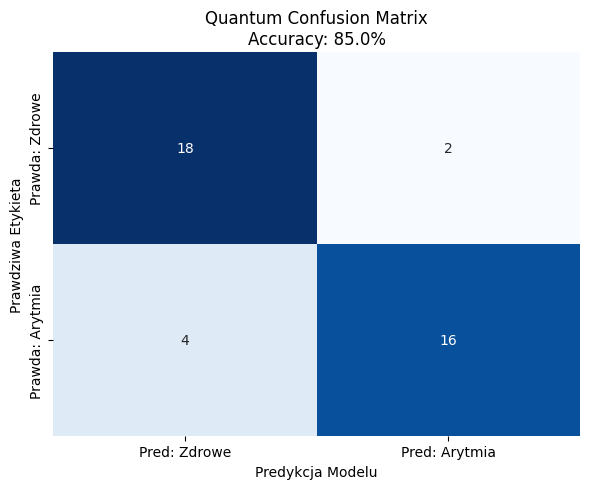

In [36]:
# =============================================
# DODATEK: WIZUALIZACJA MACIERZY POMYŁEK
# =============================================

print("\n>>> Generowanie Macierzy Pomyłek...")

# 1. USTAWIENIE PROGU (THRESHOLD)
# Patrząc na Twój ostatni histogram, idealne przecięcie jest w okolicy 0.14.
# Wszystko poniżej 0.14 traktujemy jako jedną klasę, powyżej jako drugą.
THRESHOLD = 0.007

# 2. PRZYGOTOWANIE ETYKIET PRAWDZIWYCH (Ground Truth)
# 0 = Zdrowe (Normal), 1 = Arytmia (Anomaly)
y_true = [0] * len(scores_ibm_norm) + [1] * len(scores_ibm_anom)

# 3. PRZYGOTOWANIE PREDYKCJI MODELU (Z uwzględnieniem INWERSJI!)
# WAŻNE: W Twoim wyniku arytmia (czerwone) ma MAŁY błąd, a zdrowe DUŻY.
# Musimy odwrócić logikę:
# Jeśli wynik < THRESHOLD -> To jest Arytmia (Klasa 1)
# Jeśli wynik > THRESHOLD -> To jest Zdrowe (Klasa 0)

y_pred = []
# Oceniamy zdrowe
for score in scores_ibm_norm:
    prediction = 0 if score < THRESHOLD else 1
    y_pred.append(prediction)

# Oceniamy chore
for score in scores_ibm_anom:
    prediction = 0 if score < THRESHOLD else 1
    y_pred.append(prediction)

# 4. OBLICZENIE METRYK
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print(f"--- WYNIKI DLA PROGU {THRESHOLD} ---")
print(f"Dokładność (Accuracy): {acc:.2%}")
print(f"Precyzja (Precision):  {prec:.2%} (Ile z wykrytych arytmii to faktycznie arytmie?)")
print(f"Czułość (Recall):      {rec:.2%} (Ile z prawdziwych arytmii udało się wykryć?)")

# 5. RYSOWANIE ŁADNEJ MACIERZY (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Zdrowe', 'Pred: Arytmia'],
            yticklabels=['Prawda: Zdrowe', 'Prawda: Arytmia'])
plt.title(f'Quantum Confusion Matrix\nAccuracy: {acc:.1%}')
plt.ylabel('Prawdziwa Etykieta')
plt.xlabel('Predykcja Modelu')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
# plt.show() # Zakomentowane, bo show() będzie na końcu głównego skryptu